In [ ]:
# === colab configuration ===
# p.s. when training on colab, weights are saved on Drive (directory DSCAS/weights).
# p.p.s. skip this cell if running demo file locally!

! pip install torch-summary
! pip install ray
from google.colab import drive
import sys

# setting paths
repository_path = '/content/deep-seasonal-color-analysis-system/'
dataset_path = repository_path + 'headsegmentation_dataset_ccncsa/'
dataset_path_drive = '/content/drive/MyDrive/DSCAS/headsegmentation_dataset_ccncsa/'
weights_path = repository_path + 'models/weights/'
weights_path_drive = '/content/drive/MyDrive/DSCAS/weights/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/mrcmich/deep-seasonal-color-analysis-system.git
! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'fastscnn_hyperparameters_tuning__refactoring'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

In [1]:
import torch
from torch import nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.local.FastSCNN.models import fast_scnn
from metrics_and_losses import metrics
from utils import segmentation_labels, utils
import matplotlib.pyplot as plt
from palette_classification import color_processing
import torchsummary
from models import config

try:
  executing_on_colab
except NameError:
  executing_on_colab = False
  weights_path = config.WEIGHTS_PATH
  dataset_path = config.DATASET_PATH

In [2]:
# defining transforms
tH, tW = 256, 256
image_transform = T.Compose([T.Resize((tH, tW)), T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])
target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, file_name=config.DATASET_INDEX_NAME)
X_train, X_test, Y_train, Y_test = train_test_split(
    img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
train_dataset = dataset.CcncsaDataset(X_train, Y_train, image_transform, target_transform)
test_dataset = dataset.CcncsaDataset(X_test, Y_test, image_transform, target_transform)

# training and test hyperparameters
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'fast_scnn_ccncsa'

In [3]:
# training hyperparameters
n_epochs = 50

# model, loss, score function
model = fast_scnn.FastSCNN(n_classes)
loss_fn = nn.CrossEntropyLoss()
score_fn = metrics.batch_mIoU

# optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# printing model summary
model_summary = torchsummary.summary(model, input_data=(batch_size, 3, tH, tW), batch_dim=None, verbose=0)
print(model_summary)

Layer (type:depth-idx)                   Output Shape              Param #
├─LearningToDownsample: 1-1              [32, 64, 32, 32]          --
|    └─_ConvBNReLU: 2-1                  [32, 32, 127, 127]        --
|    |    └─Sequential: 3-1              [32, 32, 127, 127]        928
|    └─_DSConv: 2-2                      [32, 48, 64, 64]          --
|    |    └─Sequential: 3-2              [32, 48, 64, 64]          1,984
|    └─_DSConv: 2-3                      [32, 64, 32, 32]          --
|    |    └─Sequential: 3-3              [32, 64, 32, 32]          3,728
├─GlobalFeatureExtractor: 1-2            [32, 128, 8, 8]           --
|    └─Sequential: 2-4                   [32, 64, 16, 16]          --
|    |    └─LinearBottleneck: 3-4        [32, 64, 16, 16]          54,272
|    |    └─LinearBottleneck: 3-5        [32, 64, 16, 16]          54,272
|    |    └─LinearBottleneck: 3-6        [32, 64, 16, 16]          54,272
|    └─Sequential: 2-5                   [32, 96, 8, 8]           

In [ ]:
# training
results = training_and_testing.train_model(
    device, model, train_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
    lr_scheduler=None, evaluate=True, verbose=True)

Device: cuda.
--- Epoch 1/50 ---
average_train_loss: 0.4928513194760706, average_train_score: 0.3826134502887726
average_val_loss: 0.4679646108831678, average_val_score: 0.4113592803478241
--- Epoch 2/50 ---
average_train_loss: 0.2879301550296637, average_train_score: 0.48354119062423706
average_val_loss: 0.23413572259365567, average_val_score: 0.5313260555267334
--- Epoch 3/50 ---
average_train_loss: 0.2226002587806805, average_train_score: 0.5390210747718811
average_val_loss: 0.21322030041899, average_val_score: 0.5449202656745911
--- Epoch 4/50 ---
average_train_loss: 0.19475000237043089, average_train_score: 0.5653524994850159
average_val_loss: 0.20391038474109438, average_val_score: 0.5658800005912781
--- Epoch 5/50 ---
average_train_loss: 0.16890079691539123, average_train_score: 0.5881263613700867
average_val_loss: 0.170779492765192, average_val_score: 0.5976690053939819
--- Epoch 6/50 ---
average_train_loss: 0.1562545557010208, average_train_score: 0.6020438075065613
average_va

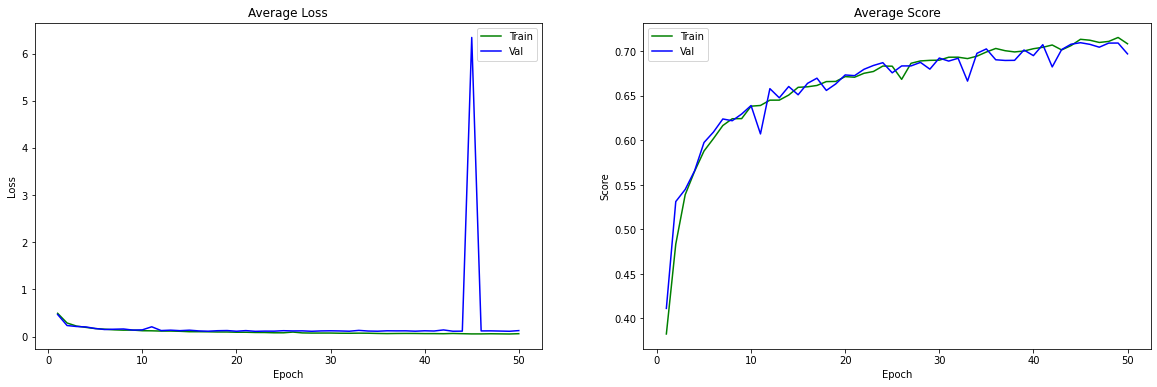

In [ ]:
# plotting training results
training_and_testing.plot_training_results(results, plotsize=(20, 6))

In [ ]:
# resetting model, optimizer, learning rate scheduler
final_model = fast_scnn.FastSCNN(n_classes)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate)

# re-training model on entire training set
final_n_epochs = n_epochs // 2
training_and_testing.train_model(
    device, final_model, train_dataset, batch_size, final_n_epochs, score_fn, loss_fn, final_optimizer, verbose=True)

# saving final model's weights
torch.save(final_model.state_dict(), weights_path + model_name + '.pth')
if executing_on_colab is True:
  torch.save(final_model.state_dict(), weights_path_drive + model_name + '.pth')

Device: cuda.
--- Epoch 1/25 ---
average_train_loss: 0.46152748055665893, average_train_score: 0.39669883251190186
--- Epoch 2/25 ---
average_train_loss: 0.2660315448089027, average_train_score: 0.4983963072299957
--- Epoch 3/25 ---
average_train_loss: 0.2071742715616203, average_train_score: 0.5503302216529846
--- Epoch 4/25 ---
average_train_loss: 0.17937420878658572, average_train_score: 0.5769771337509155
--- Epoch 5/25 ---
average_train_loss: 0.15976556662930125, average_train_score: 0.5976456999778748
--- Epoch 6/25 ---
average_train_loss: 0.14435678671765848, average_train_score: 0.6109021306037903
--- Epoch 7/25 ---
average_train_loss: 0.13785055521469716, average_train_score: 0.6203754544258118
--- Epoch 8/25 ---
average_train_loss: 0.13521047126835542, average_train_score: 0.6261231303215027
--- Epoch 9/25 ---
average_train_loss: 0.13137416556008502, average_train_score: 0.6307772397994995
--- Epoch 10/25 ---
average_train_loss: 0.11663416761354731, average_train_score: 0.645

In [4]:
# loading pretrained final model
try:
    final_model
except:
    final_model = fast_scnn.FastSCNN(n_classes)
    final_model.load_state_dict(torch.load(weights_path + model_name + '.pth'))

# testing model on test dataset
test_score_fn = metrics.batch_IoU
class_weights = torch.tensor(config.CLASS_WEIGHTS, device=device)
batch_IoU = training_and_testing.test_model(device, final_model, test_dataset, batch_size, test_score_fn)

# printing test report
training_and_testing.print_IoU_report(batch_IoU, class_weights)

Device: cuda.

Inference completed in around 52 seconds.
batch_IoU_background: 0.9539209604263306
batch_IoU_lips: 0.5102912187576294
batch_IoU_eyes: 0.39534372091293335
batch_IoU_nose: 0.6723980903625488
batch_IoU_skin: 0.8540289402008057
batch_IoU_hair: 0.7834410667419434
batch_IoU_eyebrows: 0.38010573387145996
batch_IoU_ears: 0.65069180727005
batch_IoU_teeth: 0.6487696766853333
batch_IoU_beard: 0.835120439529419
batch_IoU_sunglasses: 0.9042220115661621
batch_mIoU=0.6898486018180847
batch_weighted_mIoU=0.6686830520629883


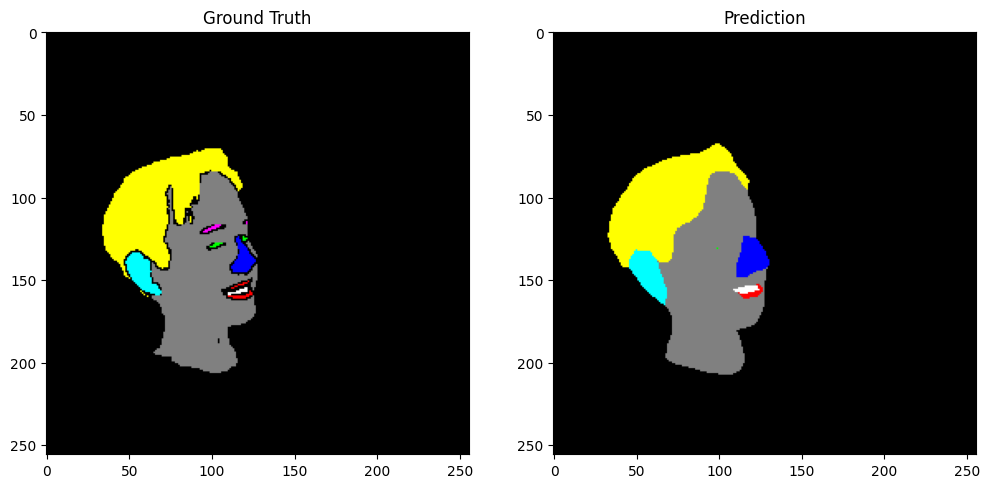

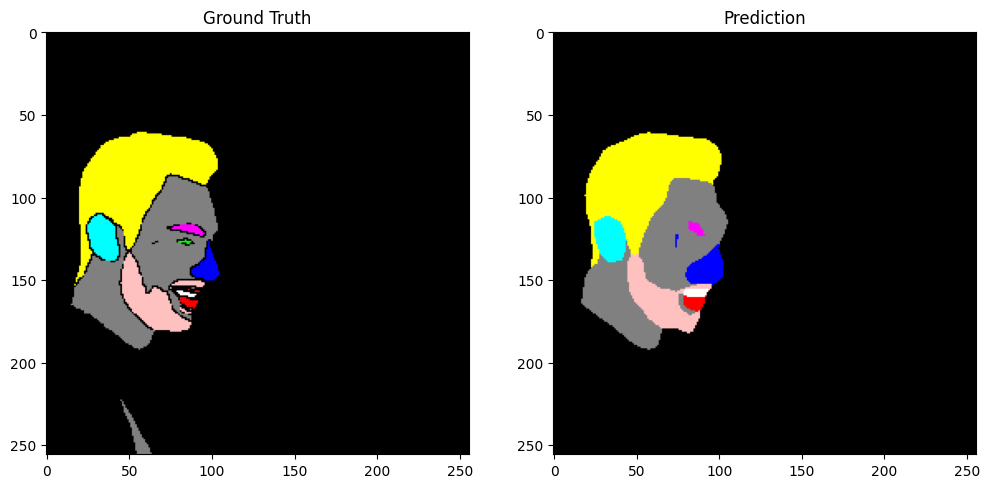

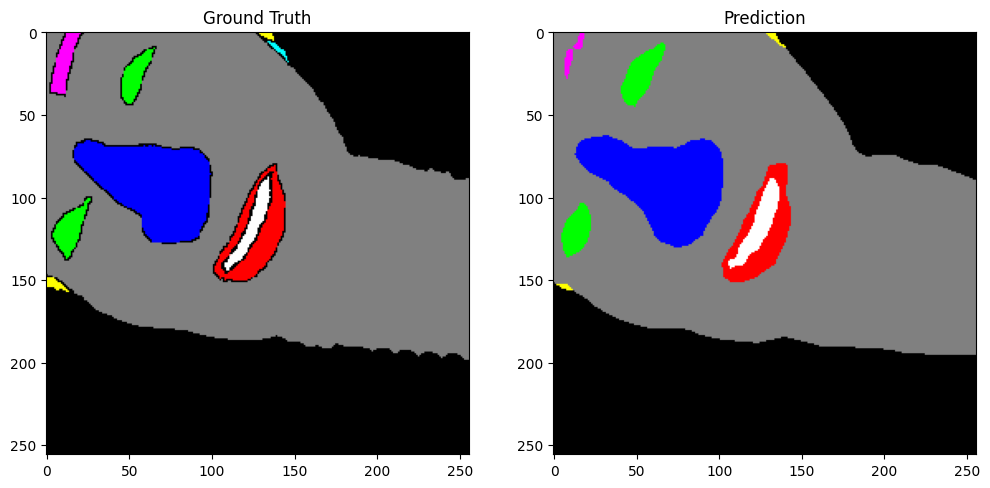

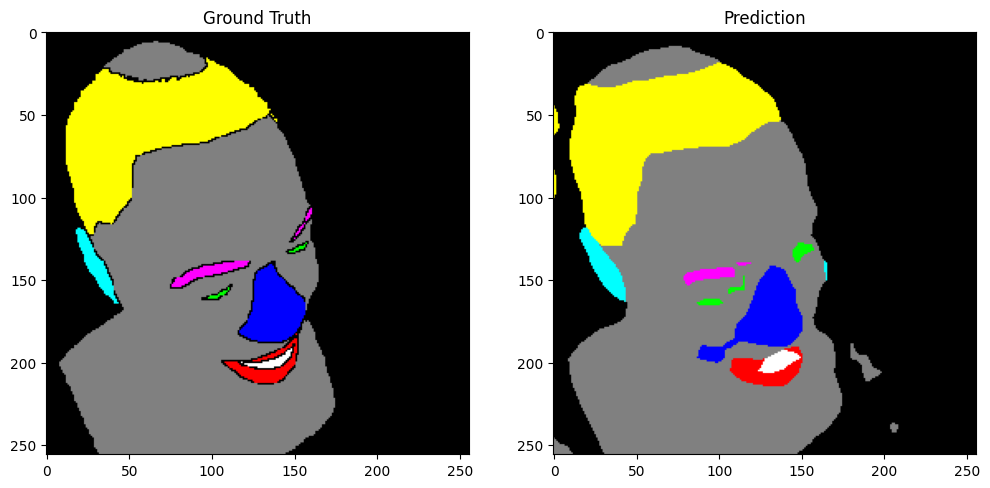

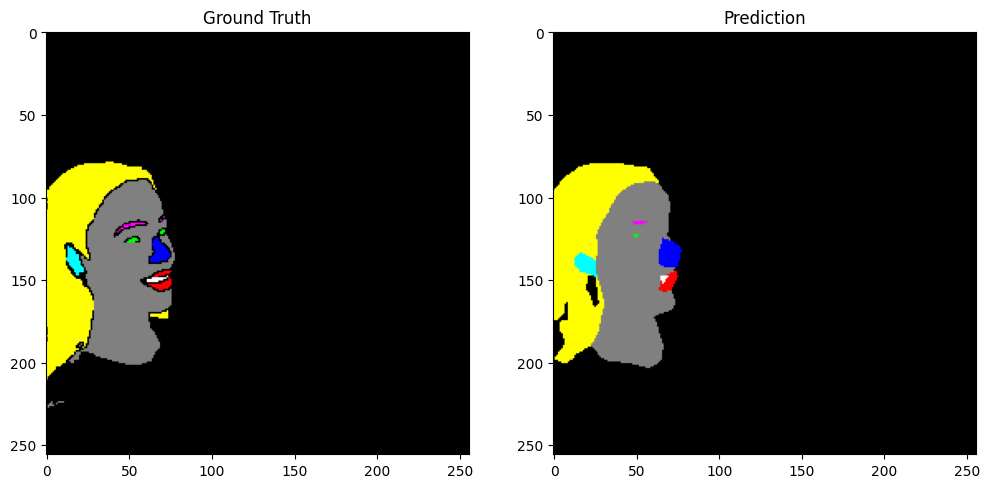

In [5]:
# plotting some examples from test dataset
utils.plot_random_examples(device, final_model, test_dataset, n_examples=5)